In [1]:
from foundry.diffusion import DDPMSchedule

In [15]:
import jax
import foundry.numpy as jnp

R = 2
N = 1024
epsilon = 2

p = 2
q = 3
P = p * q
d = int(jnp.ceil(jnp.log(P)/jnp.log(2)))
@jax.jit
def one_way(x):
    val = from_signed(x)
    return to_signed(jnp.mod(val*val, P))

P = 2
d = 1
def one_way(x):
    return x

powers = 2**jnp.arange(d)[::-1]
def to_signed(x):
    bits = jax.vmap(lambda x, y: jnp.mod(jnp.right_shift(x, y), 2),
                    in_axes=(None, 0))(
        x, jnp.arange(d)[::-1]
    )
    return bits*2 - 1
def from_signed(x):
    bits = (x + 1) // 2
    return bits.dot(powers)

@jax.jit
def sample_g_s(rng_key, s):
    lower_half = jax.random.normal(rng_key, (d,)) + R * s
    b = one_way(s)
    upper_half = jax.random.normal(rng_key, (d,))
    upper_half = jnp.round(upper_half / epsilon) * epsilon
    upper_half = upper_half +  (b + 1)/2 * epsilon/2
    return (lower_half, upper_half)

@jax.jit
def sample(rng_key):
    r_a, r_b = jax.random.split(rng_key)
    s = jax.vmap(lambda r: jax.random.choice(r, jnp.array([-1, 1])))(
        jax.random.split(r_a, d)
    )
    val = jax.random.randint(r_b, (), minval=0, maxval=P)
    s = to_signed(val)
    return sample_g_s(r_b, s)

x, y = jax.vmap(sample)(jax.random.split(jax.random.PRNGKey(42), N))

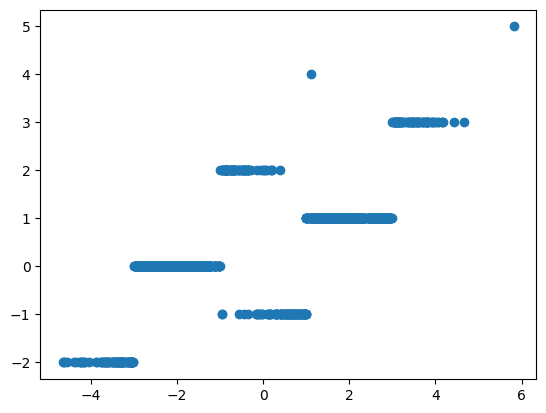

In [16]:
if d == 1:
    import matplotlib.pyplot as plt
    plt.scatter(x.squeeze(-1), y.squeeze(-1))

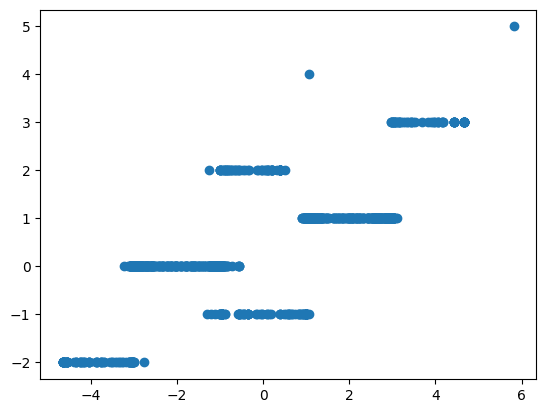

In [17]:
from foundry.diffusion import nonparametric

schedule = DDPMSchedule.make_squaredcos_cap_v2(100, prediction_type="sample")
@jax.jit
def diffuse_lower_half(rng_key, upper_half):
    diffuser = nonparametric.nw_cond_diffuser(upper_half, (y, x),
                schedule, nonparametric.log_gaussian_kernel, epsilon/32)
    # diffuser = nonparametric.closest_diffuser(upper_half, (y, x))
    return schedule.sample(rng_key, diffuser, x[0])

if d == 1:
    x_hats = jax.vmap(diffuse_lower_half)(
        jax.random.split(jax.random.key(42), N),
        y
    )
    import matplotlib.pyplot as plt
    plt.scatter(x_hats.squeeze(-1), y.squeeze(-1))

In [18]:
@jax.jit
def try_invert(rng_key, f_s):
    r_a, r_b = jax.random.split(rng_key)
    b = f_s
    upper_half = jax.random.normal(r_a, (d,))
    upper_half = jnp.round(upper_half / epsilon) * epsilon
    upper_half = upper_half +  (b + 1)/2 * epsilon/2
    lower_half = diffuse_lower_half(r_b, upper_half)
    s_hat = jnp.sign(lower_half)
    return s_hat

@jax.jit
def invert(f_s):
    keys = jax.random.split(jax.random.key(42), 512*d)
    inversions = jax.vmap(try_invert, in_axes=(0, None))(keys, f_s)
    return jax.scipy.stats.mode(inversions).mode

In [19]:
def test_one_way(v):
    output = one_way(to_signed(v))
    return from_signed(invert(output))
jax.vmap(test_one_way)(jnp.arange(P))

Array([0., 1.], dtype=float32)